In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Path rephraser 
def path_rephraser(path: str) -> str:
    return path.replace('\\', '/')

#print(rephrased_path)  # Output: C:/Users/jj402/Desktop/ML
# Rephrase the file path

path = r"C:\Users\jj402\Desktop\ML\loan_default_ml\data\application_train.csv"
rephrased_path = path_rephraser(path)

# Load the dataset
data = pd.read_csv(rephrased_path)

In [3]:
# Missing values table and the mean 
# Identify the null values in each column, find the mean of the missing null values and convert to percentage and then solve it with worst offenders first.

missing_pct = (data.isnull().mean() * 100).sort_values(ascending=False)
# remove columns with 0% missing values

missing_pct = missing_pct[missing_pct > 0.0]

# Filtering the columns related to housing details like 'COMMONAREA_AVG' for combining the housing missingness indicator

housing_columns = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']
housing_cols = []

for i in housing_columns: # Removing the subscript 'AVG' in all the columns
    if i.endswith('_AVG'):
        z = i.replace('_AVG','_') 
        housing_cols.append(z)

housing_columns = [ # storing all the housing details related columns with different subscripts like 'AVG', 'MODE', etc
    col for col in data.columns
    if col.startswith(tuple(housing_cols))
]

# Addition of the missingness indicator for all the features related to housing details

data['housing_info_missing'] = (
    data[housing_columns].isnull().all(axis=1)
).astype(int)

#data['housing_info_missing'].value_counts(normalize=True)

# Missingness indicators for external sources
data['EXT_SOURCE_1_missing'] = data['EXT_SOURCE_1'].isnull().astype(int)
data['EXT_SOURCE_3_missing'] = data['EXT_SOURCE_3'].isnull().astype(int)
data['EXT_SOURCE_3_missing'] = data['EXT_SOURCE_3'].isnull().astype(int)

# Credit enquiry details missingness indicators
credit_enquiry_cols = [
    col for col in data.columns
    if col.startswith('AMT_REQ_CREDIT_BUREAU')
]

data['Credit_info_missing'] = (
    data[credit_enquiry_cols].isnull().all(axis=1).astype(int)
)

data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].fillna('Not_Applicable') 
# Not adding a missing flag for this case instead encoding a new category for not applicable for unemployed or pensioners


# New features based on credit ratios 
data['credit_income_ratio'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['annuity_income_ratio'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['employment_age_ratio'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

data.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\jj402\AppData\Local\Temp\ipykernel_8376\2397488074.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['housing_info_missing'] = (
C:\Users\jj402\AppData\Local\Temp\ipykernel_8376\2397488074.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['EXT_SOURCE_1_missing'] = data['EXT_SOURCE_1'].isnull().astype(int)
C:\Users\jj402\AppData\Local\Temp\ipykernel_8376\2397488074.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,housing_info_missing,EXT_SOURCE_1_missing,EXT_SOURCE_3_missing,Credit_info_missing,credit_income_ratio,annuity_income_ratio,employment_age_ratio
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,1.0,0,0,0,0,2.007889,0.121978,0.067329
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0,0,1,0,4.790750,0.132217,0.070862
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,1,1,0,0,2.000000,0.100000,0.011814
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,1,1,1,1,2.316167,0.219900,0.159905
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,1,1,1,0,4.222222,0.179963,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,0,0,1,1,1.617143,0.174971,0.025303
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,0,1,1,1,3.743750,0.166687,-17.580890
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1.0,0.0,1.0,0,0,0,0,4.429176,0.195941,0.529266
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0,1,0,0,2.164368,0.118158,0.400134


In [4]:
#Splitting the dataset into training and testing sets

y = data['TARGET']
X = data.drop(columns=['TARGET'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 42, stratify= y)

if y_train.value_counts(normalize=True).all() == y_test.value_counts(normalize=True).all():
    print("\nBoth the splits are same\n") 
else : 
    print("\nBoth the sets are not same\n")


Both the splits are same



In [5]:
# Splitting the numerical columns and categorical columns separately for imputation 

num_cols = X_train.select_dtypes(include = ['int64','float64']).columns
cat_cols = X_train.select_dtypes(include = ['str']).columns

# Preprocessing Imputer pipelines are defined for numeric and categorical values separately

numeric_pipeline_wo_scal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_pipeline = Pipeline( steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# Definition of the Preprocessor block using the imputer pipelines 

preprocessor_tree = ColumnTransformer(
    transformers = [
        ('num', numeric_pipeline_wo_scal, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ]
)

In [6]:
evaluation_df = pd.DataFrame(columns=[
        "model_name",
        "roc_auc",
        "recall", 
        "precision",
        "f1_score"
    ])


In [7]:
# Training a random forest classifier model after adding class weight

from sklearn.ensemble import RandomForestClassifier

rf_model_2 = Pipeline(steps=[
    ('preprocessor',preprocessor_tree),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=50,
        n_jobs=1,
        random_state=42,        
        class_weight='balanced'
    ))
])


In [8]:
# Setup of the k-fold cross-validation
cv = StratifiedKFold(
    n_splits=5,
    shuffle= True,
    random_state=42
)

rf_cv_scores_base = cross_val_score(
    rf_model_2, 
    X_train,
    y_train, 
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

rf_cv_scores_base, rf_cv_scores_base.mean(), rf_cv_scores_base.std()

(array([0.72527721, 0.72899127, 0.72982154, 0.72683988, 0.72347298]),
 np.float64(0.7268805757511123),
 np.float64(0.0023361704562258525))

In [ ]:
# Tuning of the parameters of the random_forest model to identify the best values for the params through grid_search

param_grid = {
    'classifier__max_depth':[6,8,10],
    'classifier__min_samples_leaf': [20,50,100],
    'classifier__n_estimators': [100,200]
}

grid = GridSearchCV(
    estimator = rf_model_2,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

In [31]:
rf_model_3 = Pipeline(steps=[
    ('preprocessor',preprocessor_tree),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=100,
        n_jobs=1,
        random_state=42,        
        class_weight='balanced'
    ))
])

best_rf = rf_model_3.fit(X_train, y_train)

In [32]:
#best_rf = grid.best_estimator_

y_proba_best_rf = best_rf.predict_proba(X_test)[:,1]
y_pred_best_rf = best_rf.predict(X_test)

roc_auc_best_rf = roc_auc_score(y_test, y_proba_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)

evaluation_df.loc[len(evaluation_df)] = {"model_name": "Best_Random_Forest", "roc_auc": roc_auc_best_rf, "recall": recall_best_rf, "precision": precision_best_rf, "f1_score": f1_best_rf}

evaluation_df

,model_name,roc_auc,recall,precision,f1_score
0,Best_Random_Forest,0.734838,0.631823,0.162002,0.257882
1,Best_Random_Forest,0.744014,0.516818,0.194012,0.282118
2,Best_Random_Forest,0.731069,0.641490,0.157510,0.252918
3,Best_Random_Forest,0.734838,0.631823,0.162002,0.257882


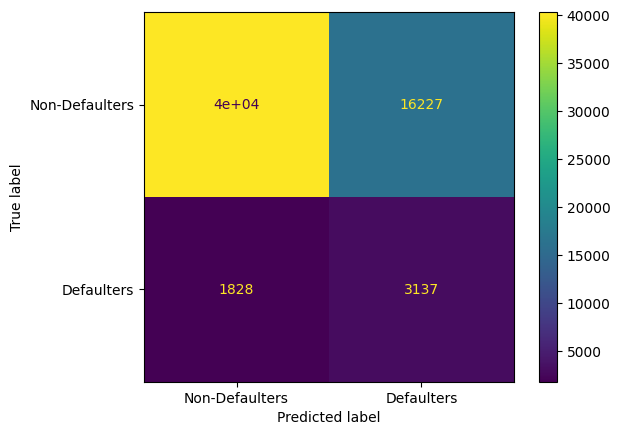

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

best_rf_cm = confusion_matrix(y_test, y_pred_best_rf)
disp = ConfusionMatrixDisplay(
    best_rf_cm,
    display_labels=['Non-Defaulters', 'Defaulters']
)
disp.plot()
plt.show()


### Day 5
* To understand the concepts of bias, variance and perform error analysis
* Plot learning curves 
* Understand why certain errors are occuring

In [34]:
from sklearn.model_selection import learning_curve
import numpy as np 
import matplotlib as plt

In [35]:
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, 
    X_train, 
    y_train, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes = np.linspace(0.1,1,5)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

train_mean, val_mean

(array([0.82284298, 0.79939449, 0.78852791, 0.78172041, 0.77745876]),
 array([0.72237095, 0.72895035, 0.73089139, 0.73060326, 0.73138362]))

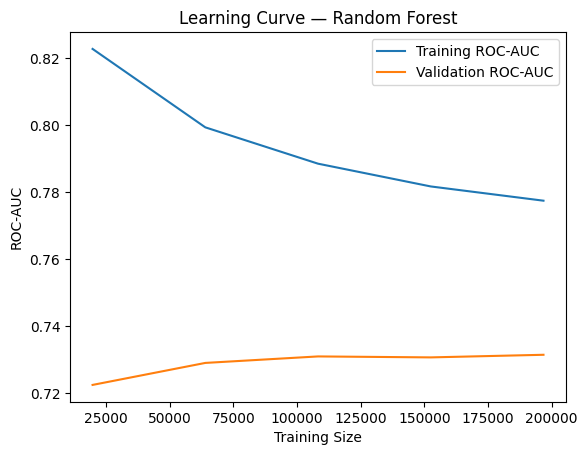

In [36]:
import matplotlib.pyplot as plt

plt.plot(train_sizes, train_mean, label='Training ROC-AUC')
plt.plot(train_sizes, val_mean, label='Validation ROC-AUC')
plt.xlabel('Training Size')
plt.ylabel('ROC-AUC')
plt.title('Learning Curve — Random Forest')
plt.legend()
plt.show()

In [37]:
y_proba_best_rf= best_rf.predict_proba(X_test)[:,1]
subset = X_test['EXT_SOURCE_3_missing'] == 1
roc_auc_score(y_test[subset], y_proba_best_rf[subset])


0.7050104733465757

In [43]:
# AMT_CREDIT
# AMT_REQ_CREDIT_BUREAU_MON
# credit_income_ratio
# employment_age_ratio

subset_1 = X_test['AMT_CREDIT'] >= 500000
print("Performance of AMT_Credit >= 500000 : ", roc_auc_score(y_test[subset_1], y_proba_best_rf[subset_1]))

subset_2 = X_test['AMT_CREDIT'] <500000
print("Performance of AMT_Credit < 500000 : ", roc_auc_score(y_test[subset_2], y_proba_best_rf[subset_2]))



Performance of AMT_Credit >= 500000 :  0.7360059649684746
Performance of AMT_Credit < 500000 :  0.7352942808711421


In [56]:
subset_3 = X_test['credit_income_ratio'] >= 3.2
subset_4 = X_test['credit_income_ratio'] <3.2
print("Performance of credit_income_ratio >= 3.2 : ", roc_auc_score(y_test[subset_3], y_proba_best_rf[subset_3]))
print("Performance of credit_income_ratio <  3.2 : ", roc_auc_score(y_test[subset_4], y_proba_best_rf[subset_4]))

Performance of credit_income_ratio >= 3.2 :  0.7320815724837353
Performance of credit_income_ratio <  3.2 :  0.7378960320169663


### Slice-Based Error Analysis

Model performance remains stable across loan size segments, indicating that risk
is captured proportionally rather than by absolute credit amount. However, performance
drops for applicants with missing external credit scores, suggesting that lack of
credit history represents an inherently harder-to-predict subgroup. High credit-to-
income applicants also show slightly reduced predictability, reflecting increased
financial uncertainty rather than modeling error.


## Day 5 — Bias–Variance & Error Analysis Summary

- The model is moderately variance-limited, as it achieves higher training ROC-AUC than validation ROC-AUC.
- Learning curves show a persistent but stable gap between training and validation performance, with the validation curve plateauing as data increases, indicating limited gains from further tuning.
- The most common error type is false positives, driven by class-weighted training that prioritizes recall and by uncertainty in cases with limited external credit information.
- The next concrete improvement would be decision-threshold tuning to balance recall and precision, followed by feature pruning or aggregation to reduce redundancy before considering a more complex model.
